## Imports ##

In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR

import pandas as pd
import pickle
import numpy as np

#### Datasets

In [69]:
# drugs
drugs = pd.read_csv('./data/drugs.csv', index_col=1)
drugs.drop(['Unnamed: 0'], axis=1, inplace=True)

# cell lines
cell_lines = pd.read_csv('./data/gene_expression.csv', index_col=0)

# combinations
combinations = pd.read_csv('./data/combinations.csv', index_col=0)

In [70]:
# reduce cell lines to the 2128 most important genes

with open('./data/2128_genes.pkl', 'rb') as f:
    top_genes = pickle.load(f)

filtered_cell_lines = cell_lines[cell_lines.columns.intersection(top_genes)]

In [71]:
filtered_cell_lines

,FUCA2,GCLC,STPG1,CYP26B1,NDUFAB1,ABCB5,DVL2,HOXA11,COPZ2,CREBBP,...,ATP6V1E2,ZNF345,ATXN7L3B,PRKDC,PBOV1,OR13A1,ZNF253,MRPL46,OR1D5,MYH4
HCC1954,7.553067,9.280913,3.372573,3.777488,10.985991,2.902166,4.193197,3.967413,3.356586,5.688428,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
HCC1143,8.440833,8.005206,3.920152,3.210161,10.541755,2.877320,5.040755,6.764679,4.920267,5.519528,...,4.663152,3.235018,6.002967,6.837048,3.135009,3.479925,3.393041,7.479672,3.238828,2.564325
HCC1187,5.551352,5.032812,3.528140,3.247300,10.967920,2.934802,4.944361,2.851308,3.645263,5.802317,...,4.656409,5.170385,6.394137,6.492606,3.192293,3.580566,6.013642,8.186395,3.350337,2.914548
HCC1395,8.245466,5.650228,4.185011,3.259254,11.115642,2.933936,5.516593,3.286230,3.768223,5.700710,...,5.917166,3.719701,5.434950,6.151482,3.192478,3.430052,3.542136,8.426703,3.334150,2.641512
HCC1599,7.464137,6.321866,3.531019,5.513162,11.556747,2.998914,4.427619,4.466376,3.336529,6.209780,...,5.204575,6.172346,6.329224,7.900965,2.989608,3.189426,5.394498,8.710373,3.201282,2.749716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCC010,8.031837,6.249088,3.978721,2.909780,11.181177,2.976709,4.335160,3.422648,3.871866,5.911000,...,3.595436,2.765286,5.695328,7.166143,2.982351,3.260054,3.129891,8.034300,3.532607,2.621257
RCC-JW,7.988237,4.217507,3.394038,2.684415,10.388300,3.006199,5.041662,3.457660,7.311520,4.917703,...,3.836706,4.589799,5.231567,6.250817,2.912933,3.436972,3.731778,8.165442,3.789976,2.609469
MM1S,6.453126,5.564713,3.394151,3.028858,11.651180,3.102640,5.167779,2.848341,4.205521,6.021638,...,3.983349,4.146940,5.640954,6.672501,3.203864,3.294515,4.703204,8.485069,3.427507,2.669626
SNU-61,8.947314,6.013510,3.725530,3.029182,11.244912,3.123017,4.957366,5.788725,4.130588,6.112583,...,4.522754,2.724952,5.866326,5.720577,3.067657,3.452590,3.529156,8.440759,3.312884,2.772584


### Merge data

In [72]:
drugs

,Drug
Drug_ID,
Camptothecin,CC[C@@]1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=...
Vinblastine,CC[C@@]1(CC2C[C@@](C3=C(CCN(C2)C1)C4=CC=CC=C4N...
Cisplatin,N.N.[Cl-].[Cl-].[Pt+2]
Cytarabine,C1=CN(C(=O)N=C1N)[C@H]2[C@H]([C@@H]([C@H](O2)C...
Docetaxel,CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...
...,...
LJI308,C1COCCN1C2=CC=C(C=C2)C3=C(C=NC=C3)C4=CC(=C(C(=...
GSK591,C1CC(C1)NC2=NC=CC(=C2)C(=O)NC[C@@H](CN3CCC4=CC...
VE821,CS(=O)(=O)C1=CC=C(C=C1)C2=CN=C(C(=N2)C(=O)NC3=...


In [73]:
# transform smiles to fingerprints
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=512)
    return fp

def smiles_to_maccs(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = MACCSkeys.GenMACCSKeys(mol)
    return fp

drugs['Drug'] = drugs['Drug'].apply(smiles_to_maccs)
drugs

,Drug
Drug_ID,
Camptothecin,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Vinblastine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Cisplatin,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
Cytarabine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Docetaxel,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
...,...
LJI308,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
GSK591,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
VE821,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [74]:
drugs = pd.concat([drugs.drop(['Drug'], axis=1), drugs['Drug'].apply(lambda x: pd.Series({f'fp{str(i)}': val for i, val in enumerate(x)}))], axis=1)
drugs

,fp0,fp1,fp2,fp3,fp4,fp5,fp6,fp7,fp8,fp9,...,fp157,fp158,fp159,fp160,fp161,fp162,fp163,fp164,fp165,fp166
Drug_ID,,,,,,,,,,,,,,,,,,,,,
Camptothecin,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
Vinblastine,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
Cisplatin,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
Cytarabine,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
Docetaxel,0,0,0,0,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LJI308,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
GSK591,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
VE821,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0


In [75]:
# merge cell lines and drugs considering the combinations
final_df = pd.merge(combinations, drugs, on='Drug_ID')
final_df = pd.merge(final_df, filtered_cell_lines, left_on='Cell Line_ID', right_index=True, how = 'inner')
final_df.index = final_df['Drug_ID'] + '_' + final_df['Cell Line_ID']
final_df

,Drug_ID,Cell Line_ID,Y,fp0,fp1,fp2,fp3,fp4,fp5,fp6,...,ATP6V1E2,ZNF345,ATXN7L3B,PRKDC,PBOV1,OR13A1,ZNF253,MRPL46,OR1D5,MYH4
Camptothecin_HCC1954,Camptothecin,HCC1954,-0.251083,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Vinblastine_HCC1954,Vinblastine,HCC1954,-3.058914,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Cisplatin_HCC1954,Cisplatin,HCC1954,5.005908,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Cytarabine_HCC1954,Cytarabine,HCC1954,3.947056,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Docetaxel_HCC1954,Docetaxel,HCC1954,-4.177968,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MK-2206_HCC202,MK-2206,HCC202,1.585069,0,0,0,0,0,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746
Palbociclib_HCC202,Palbociclib,HCC202,4.867165,0,0,0,0,0,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746
Pictilisib_HCC202,Pictilisib,HCC202,0.583059,0,0,0,0,0,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746
5-Fluorouracil_HCC202,5-Fluorouracil,HCC202,5.998151,0,0,0,0,0,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746


### Dataset splitting ###

In [76]:
output = final_df['Y']
input = final_df.drop(['Drug_ID', 'Cell Line_ID', 'Y'], axis=1)


In [77]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(input)
# input = scaler.transform(input)

In [78]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size=0.3, random_state=42)

In [79]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((64420, 2256), (64420,), (27609, 2256), (27609,))

In [80]:
x_train

,fp0,fp1,fp2,fp3,fp4,fp5,fp6,fp7,fp8,fp9,...,ATP6V1E2,ZNF345,ATXN7L3B,PRKDC,PBOV1,OR13A1,ZNF253,MRPL46,OR1D5,MYH4
Foretinib_SU-DHL-5,0,0,0,0,0,0,0,0,0,0,...,4.691279,4.588879,6.115306,7.192039,3.113060,3.845969,4.334785,8.598431,4.148634,2.790745
AZD5582_KYSE-510,0,0,0,0,0,0,0,0,0,0,...,5.806667,3.010023,6.071624,7.296508,2.852123,3.254496,3.603477,9.315939,3.656085,2.557605
GSK1904529A_LAMA-84,0,0,0,0,0,0,0,0,0,0,...,4.053422,6.007190,6.427173,7.604878,2.954750,3.228966,3.339378,9.219408,3.217167,2.776306
AZD7762_KYSE-410,0,0,0,0,0,0,0,0,0,0,...,4.096737,2.847874,6.208649,7.328019,2.903004,3.287460,3.438245,7.949132,3.549288,2.461553
GDC0810_HCC1937,0,0,0,0,0,0,0,0,0,0,...,4.840922,5.034253,5.504598,6.408040,2.946172,3.402678,4.110709,7.456525,3.580119,2.615916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PFI3_SW1463,0,0,0,0,0,0,0,0,0,0,...,4.793499,4.738768,6.726044,5.808590,2.832737,3.678759,4.410979,8.231673,3.377068,3.009807
I-BRD9_SW1710,0,0,0,0,0,0,0,0,0,0,...,3.964336,4.023004,5.336447,6.466790,2.940953,3.332759,3.889705,7.408880,3.686703,2.593133
Olaparib_RERF-GC-1B,0,0,0,0,0,0,0,0,0,0,...,5.960230,6.854925,6.428696,6.726985,2.792515,3.375117,3.350753,8.907326,3.454210,2.510775
Crizotinib_HCC2218,0,0,0,0,0,0,0,0,0,0,...,4.061743,3.632399,6.157377,6.432589,3.374558,3.612480,3.698259,8.743277,3.809671,2.523288


## Clustering

In [104]:
cell_lines_info = pd.read_csv('./data/updated_cell_lines_info.csv', index_col=0)

In [109]:
cell_lines_info.insert(0, 'Cell Line_ID', cell_lines_info.index)

In [116]:
cell_lines_info

,Cell Line_ID,Cell Line,Tissue,Tissue sub-type,Count,Mean_Y,Datasets
Cell Line_ID,,,,,,,
MDA-MB-157,MDA-MB-157,[ 5.50020891 3.10477592 10.91037142 ... 9.78...,breast,breast,136,3.126755,GDSC2
CAMA-1,CAMA-1,[ 6.90040711 2.72616293 9.57820681 ... 10.13...,breast,breast,136,2.595224,GDSC2
MDA-MB-231,MDA-MB-231,[ 7.78398332 2.84512339 10.04780926 ... 9.16...,breast,breast,136,2.527992,GDSC2
MDA-MB-415,MDA-MB-415,[ 6.3918087 2.84384587 10.27915458 ... 9.42...,breast,breast,136,2.463053,GDSC2
HCC38,HCC38,[ 7.45295425 2.88491739 10.17332196 ... 9.29...,breast,breast,136,3.554996,GDSC2
...,...,...,...,...,...,...,...
KYSE-510,KYSE-510,[ 7.74994459 2.62686567 10.29167567 ... 8.68...,aero_digestive_tract,oesophagus,28,2.318249,GDSC2
ECC12,ECC12,[ 6.30201645 2.96231026 10.02490954 ... 9.19...,digestive_system,stomach,26,3.393325,GDSC2
COR-L95,COR-L95,[5.36293426 2.55592993 9.63412195 ... 9.252285...,lung,lung_small_cell_carcinoma,20,1.215786,GDSC2


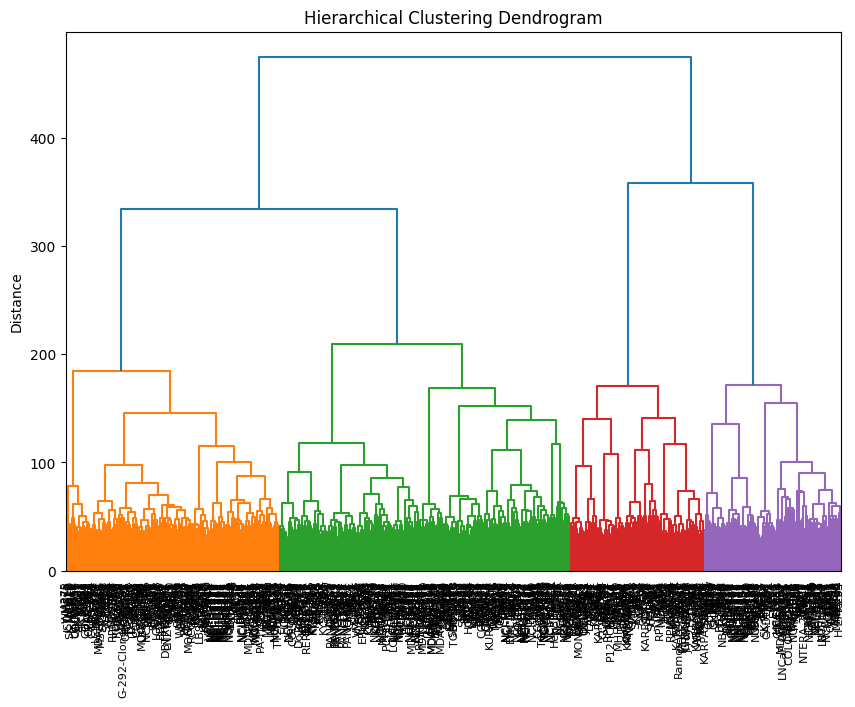

In [94]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
 
# hierarchical clustering
Z = linkage(filtered_cell_lines, method='ward')

# plotting the dendrogram
plt.figure(figsize=(10, 7))
plt.title("Hierarchical Clustering Dendrogram")
dendrogram(Z, labels=filtered_cell_lines.index, leaf_rotation=90, leaf_font_size=8)
plt.ylabel('Distance')
plt.show()

In [96]:
cell_lines_info = pd.read_csv('./data/cell_line_info.csv', index_col=0)

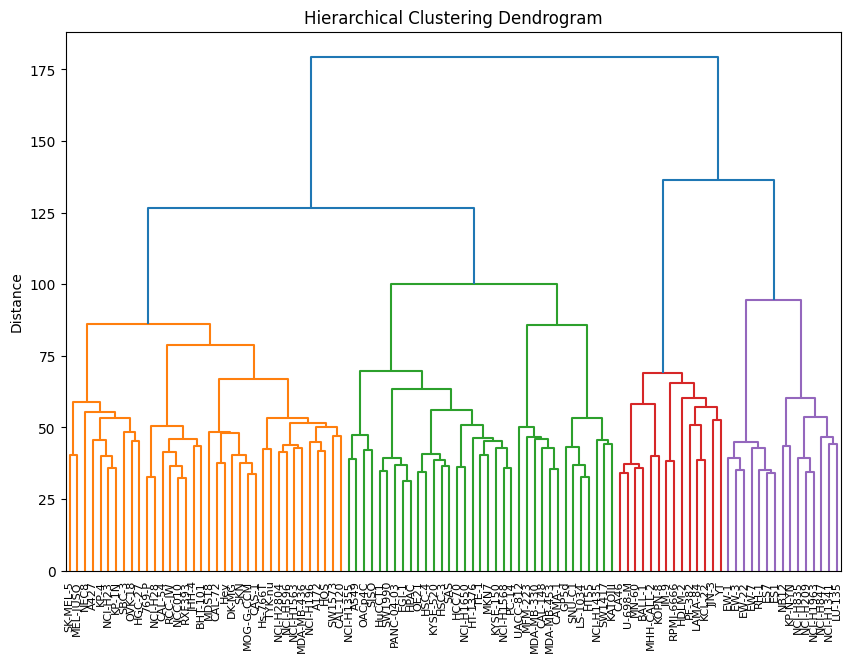

In [82]:
sampled_df = filtered_cell_lines.sample(n=100, random_state=42)
Z = linkage(sampled_df, method='ward')

plt.figure(figsize=(10, 7))
plt.title("Hierarchical Clustering Dendrogram")
dendrogram(Z, labels=sampled_df.index, leaf_rotation=90, leaf_font_size=8)
plt.ylabel('Distance')
plt.show()

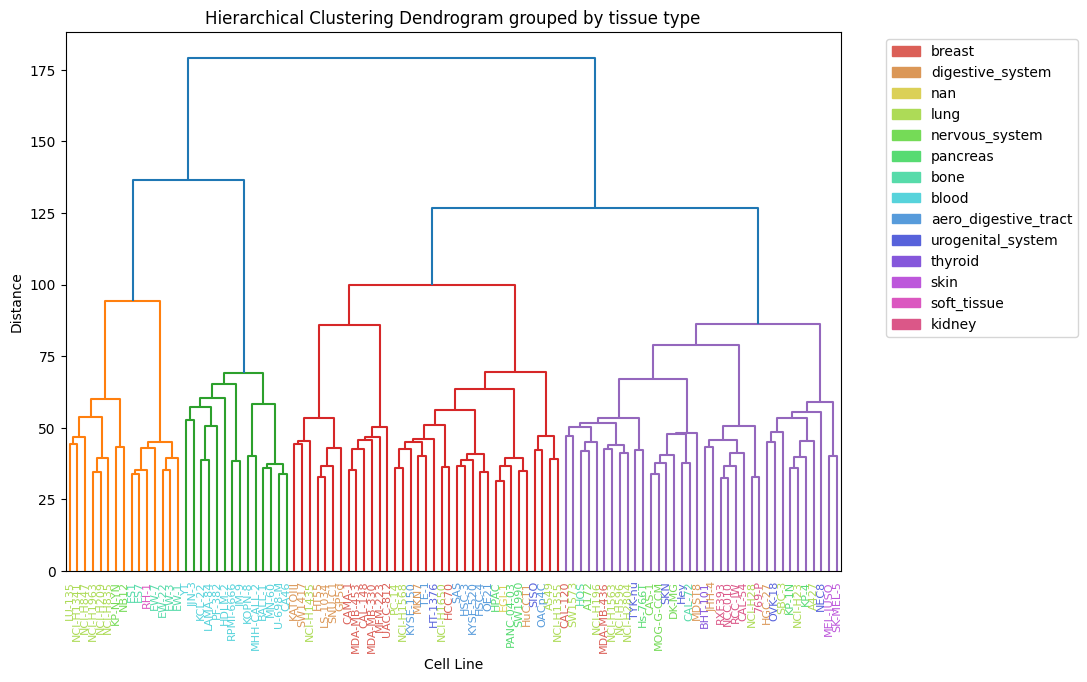

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.colors import rgb2hex, to_rgba
import random
from matplotlib.patches import Patch

# tissue_data = pd.read_excel('./data/tissue.xlsx', index_col=0)
linked = linkage(sampled_df, 'ward')
unique_sites = cell_lines_info['Tissue'].unique()
palette = sns.color_palette('hls',len(unique_sites)) 

# color dictionary 
color_dict = {tissue: rgb2hex(color) for tissue, color in zip(unique_sites, palette)}
#print(color_dict)

# mapping each cell line to its tissue color
tissue_colors = cell_lines_info.set_index('Cell Line_ID')['Tissue'].map(color_dict)

plt.figure(figsize=(10, 7))
dendro = dendrogram(linked,
                    orientation='top',
                    labels=sampled_df.index,
                    distance_sort='descending',
                    show_leaf_counts=True,
                    leaf_rotation=90,
                    leaf_font_size=8,
                    )

# apply gradient 
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
num_labels = len(xlbls)
for i, lbl in enumerate(xlbls):
    lbl.set_color(to_rgba(tissue_colors[lbl.get_text()], alpha=1))

plt.ylabel('Distance')
plt.xlabel('Cell Line')
plt.title('Hierarchical Clustering Dendrogram grouped by tissue type')

# Create a list of Patch objects, one for each unique color
legend_patches = [Patch(color=color, label=tissue) for tissue, color in color_dict.items()]

# Add the legend to your plot
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

# The rest of your plotting code...

plt.show()

## K-Means (Elbow method)

c:\Users\Ruben Fernandes\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ruben Fernandes\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ruben Fernandes\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ruben Fernandes\AppData\Local\Programs\Python\

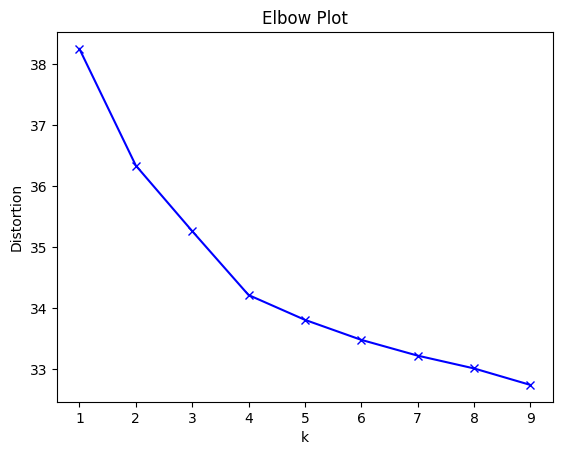

In [121]:
# do a k-means elbow plot to find the optimal number of clusters
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(filtered_cell_lines)
    kmeanModel.fit(filtered_cell_lines)
    distortions.append(sum(np.min(cdist(filtered_cell_lines, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / filtered_cell_lines.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Plot')
plt.show()


From the elbow method it is possible to see that the best number of clusters is 4

In [146]:
sampled_df

,FUCA2,GCLC,STPG1,CYP26B1,NDUFAB1,ABCB5,DVL2,HOXA11,COPZ2,CREBBP,...,ATP6V1E2,ZNF345,ATXN7L3B,PRKDC,PBOV1,OR13A1,ZNF253,MRPL46,OR1D5,MYH4
IM-9,5.813465,5.615725,3.595458,2.988285,10.964037,2.995869,4.539751,2.939836,3.482774,5.581428,...,5.220107,4.652651,6.615759,6.532102,2.975715,3.529730,3.682857,9.049231,3.606787,2.653427
NCI-H1435,8.589215,8.790613,3.722592,3.035098,11.621075,2.931228,4.324627,5.591962,5.950713,4.767050,...,4.398382,3.341788,6.728032,7.818496,2.978731,3.139854,3.261054,8.309246,3.056792,2.602227
NCI-H1355,9.290492,7.157417,3.601467,3.426552,10.997982,3.290516,5.226146,3.467900,4.383494,5.375897,...,7.318661,4.473125,5.689486,6.290950,2.785333,3.299651,3.628214,9.025185,4.174488,2.606787
A427,7.542324,4.675679,3.558924,3.233710,11.312558,2.901212,5.521837,2.988741,6.588637,5.223695,...,7.315901,5.428223,5.908524,5.676584,3.121438,3.587197,3.628188,8.280052,3.436949,2.830576
769-P,8.655140,6.230362,3.128699,3.094269,11.503459,2.911390,4.711816,3.036665,3.291291,5.123746,...,4.071419,2.872629,5.972763,6.489836,3.043427,3.292506,3.188020,8.818369,3.806957,2.682744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TYK-nu,7.738166,4.783764,4.499314,3.177108,11.230743,3.058107,4.466497,5.134559,3.621844,5.367825,...,6.495679,4.109545,6.074821,7.701981,3.019699,3.190900,3.576154,8.547836,3.394206,2.773346
Hey,8.316955,5.080891,3.726326,3.402911,11.010200,2.870198,4.649193,3.041526,4.479284,5.728058,...,4.237142,3.120362,5.899409,7.792280,3.050774,3.223728,3.054146,8.494091,3.681188,2.711305
BHT-101,8.116431,6.024521,3.637777,2.855739,10.823165,2.905324,4.984344,2.964976,4.050913,5.169115,...,4.729477,3.414514,5.725320,8.695528,2.991502,3.049456,3.512034,7.736497,3.569476,2.567721
RH-1,3.674984,5.691279,3.782902,2.938656,11.045759,2.886655,4.941811,3.983716,3.593611,5.829789,...,3.685626,6.042689,6.024477,6.227420,2.897047,3.197794,3.727481,9.085784,3.763704,2.836178


c:\Users\Ruben Fernandes\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


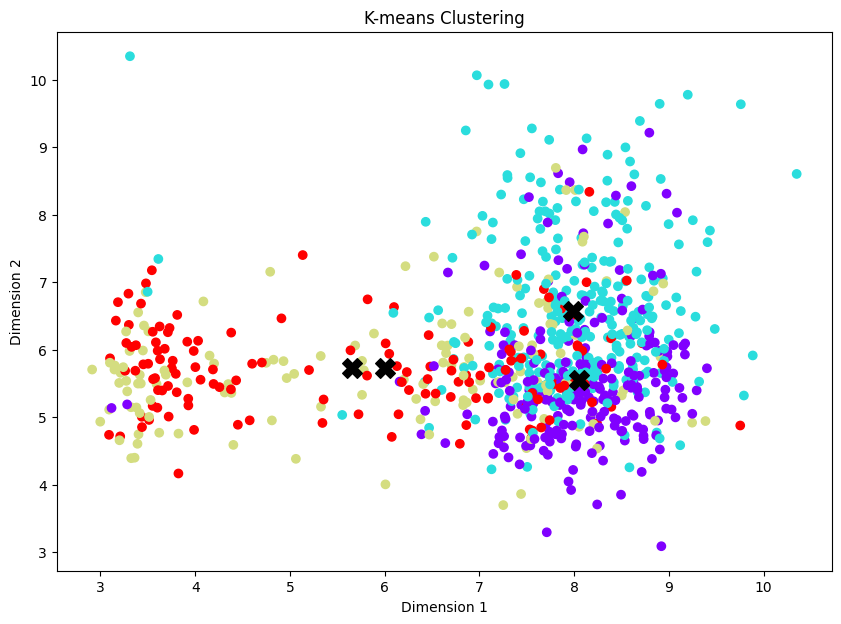

In [153]:
#K-means clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42).fit(filtered_cell_lines)
kmeans.labels_
centroids = kmeans.cluster_centers_

# plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(filtered_cell_lines.iloc[:,0], filtered_cell_lines.iloc[:,1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', c='black', s=200, alpha=1)
plt.title('K-means Clustering')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


## PCA

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
pca = PCA(n_components=0.95)
pca.fit(input)

cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()

numeber of componets for 95% explaned variance: 430


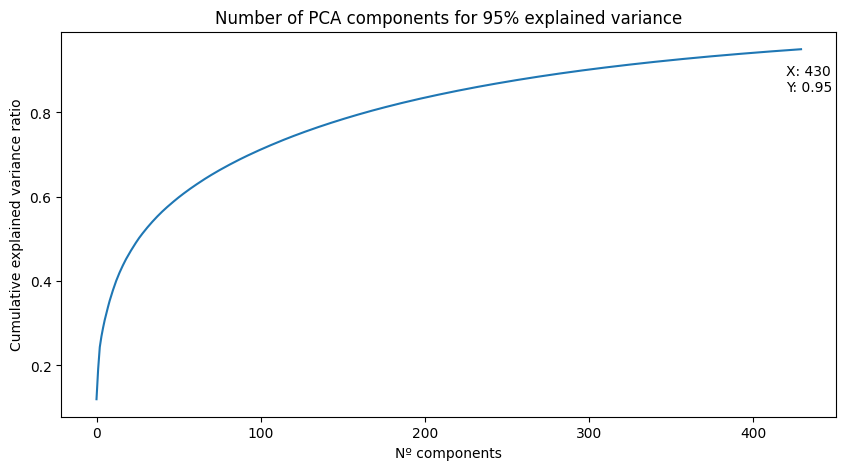

In [17]:
# number if pca for 0.95 variance
print(f'numeber of componets for 95% explaned variance:', pca.n_components_)

# plot cumulative variance

plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance_ratio)
plt.xlabel('Nº components')
plt.ylabel('Cumulative explained variance ratio')
plt.title(f'Number of PCA components for 95% explained variance')
# Add the last x and y values to the plot
last_x = pca.n_components_
last_y = cumulative_variance_ratio[-1]

offset_x = 10
offset_y = 0.1

plt.text(last_x - offset_x, last_y - offset_y, f'X: {last_x} \nY: {last_y:.2f}')

plt.show()                            


To explain 95% of the variance, it's needed 430 components from the original 2259.

In [18]:
pca = PCA(n_components=0.8)
pca.fit(input)

cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()
print('Var. explicada: %s'% str(pca.explained_variance_ratio_))
print('Soma:', sum(pca.explained_variance_ratio_) * 100, '%')
# number if pca for 80% variance
print('numeber of componets for explaned variance:', pca.n_components_)

Var. explicada: [0.11978168 0.07147367 0.05228081 0.02526206 0.02052816 0.01835545
 0.0159642  0.01504164 0.01450037 0.01290067 0.01217824 0.01158158
 0.01088883 0.00988705 0.00927269 0.00860955 0.00830396 0.00787202
 0.0075605  0.00690418 0.00679983 0.00658434 0.00634307 0.00624377
 0.0060326  0.00582674 0.00564981 0.00526342 0.00503139 0.0049167
 0.00481976 0.00474297 0.00456062 0.00445656 0.00438918 0.00422646
 0.00417833 0.00409439 0.00397435 0.00388481 0.00372159 0.00366855
 0.00353796 0.00351332 0.00342342 0.00334429 0.00333404 0.00327828
 0.00326996 0.00318745 0.00311316 0.00306842 0.00298985 0.0029516
 0.00290156 0.00286073 0.00283823 0.00279792 0.00274324 0.00269492
 0.00265014 0.0026415  0.00260816 0.00257816 0.0025514  0.00254132
 0.00251659 0.00244444 0.00243065 0.00237442 0.00234948 0.00230781
 0.00228309 0.00227075 0.00225437 0.00223696 0.00217841 0.00215301
 0.00214775 0.00211384 0.00209693 0.00208917 0.00206328 0.00204319
 0.00204066 0.00199808 0.00197121 0.00196572 0.0

To explain 80% of the variance, it's needed 96 components from the original 2259. In this case, this is a considerable reduction of the dimensionality.

### PCA train and test

In [19]:
pca = PCA(n_components=20)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)

cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()
print('Var. explicada: %s'% str(pca.explained_variance_ratio_))
print('Soma:', sum(pca.explained_variance_ratio_) * 100, '%')
# number if pca for 80% variance
print('numeber of componets for explaned variance:', pca.n_components_)

Var. explicada: [0.11967293 0.07153086 0.05222462 0.02536876 0.02052103 0.01837947
 0.015982   0.01502919 0.01451321 0.01291107 0.01218216 0.01159776
 0.01083071 0.00985296 0.00925635 0.0085669  0.00832987 0.00784083
 0.00756705 0.0068412 ]
Soma: 45.89989260667586 %
numeber of componets for explaned variance: 20


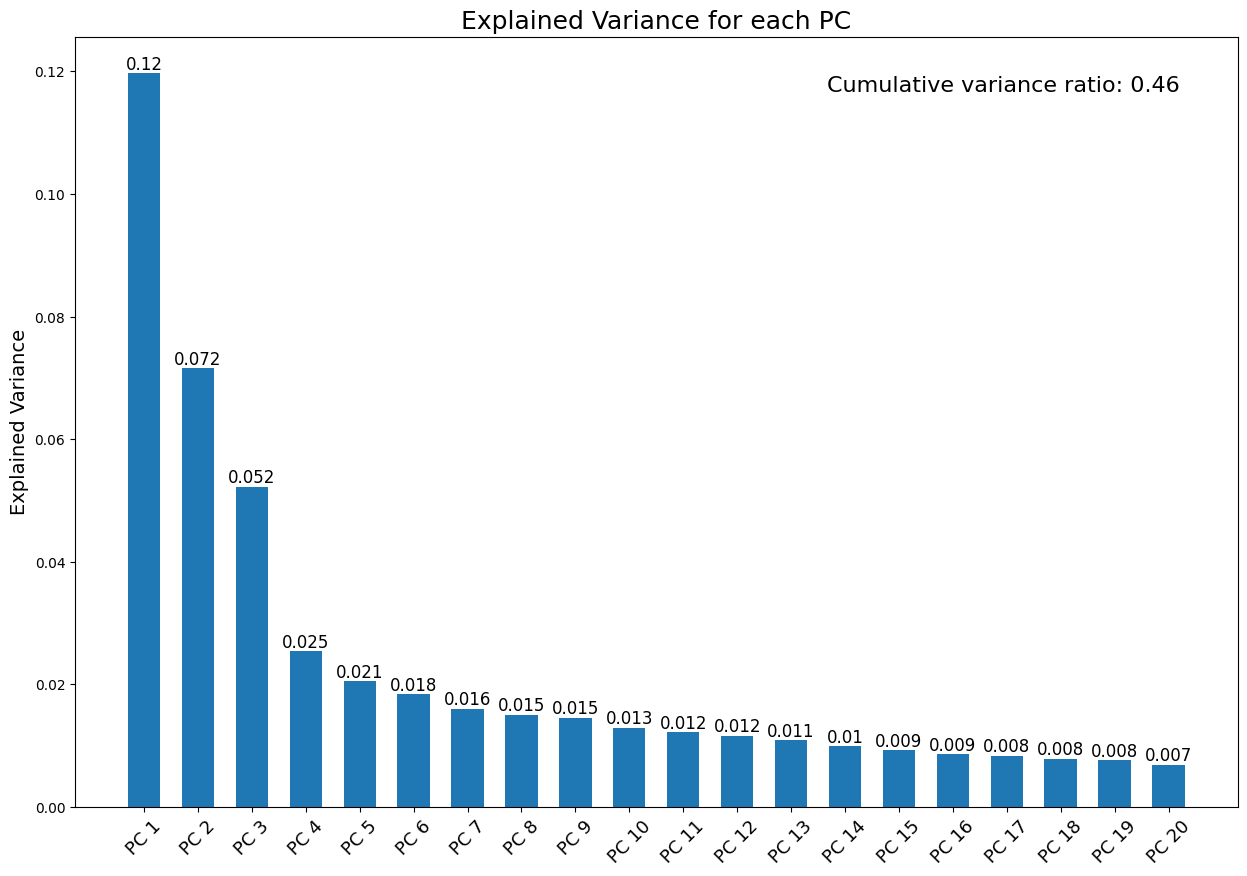

In [20]:
plt.figure(figsize=(15, 10))
bars = plt.bar(range(1, 21), pca.explained_variance_ratio_, width=0.6)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Explained Variance for each PC', fontsize=18)
# Set the x-labels to the component numbers
plt.xticks(range(1, 21), labels=[f'PC {i}' for i in range(1, 21)], rotation=45, fontsize=13)

# Add labels to each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom', fontsize=12)

plt.text(0.95, 0.95, f'Cumulative variance ratio: {cumulative_variance_ratio[-1]:.2f}', 
         ha='right', va='top', transform=plt.gca().transAxes, fontsize=16)

plt.show()

In [23]:
#pca train
pca = PCA(n_components=3)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)

#pca test
pca = PCA(n_components=3)
pca.fit(x_test)
x_test_pca = pca.transform(x_test)

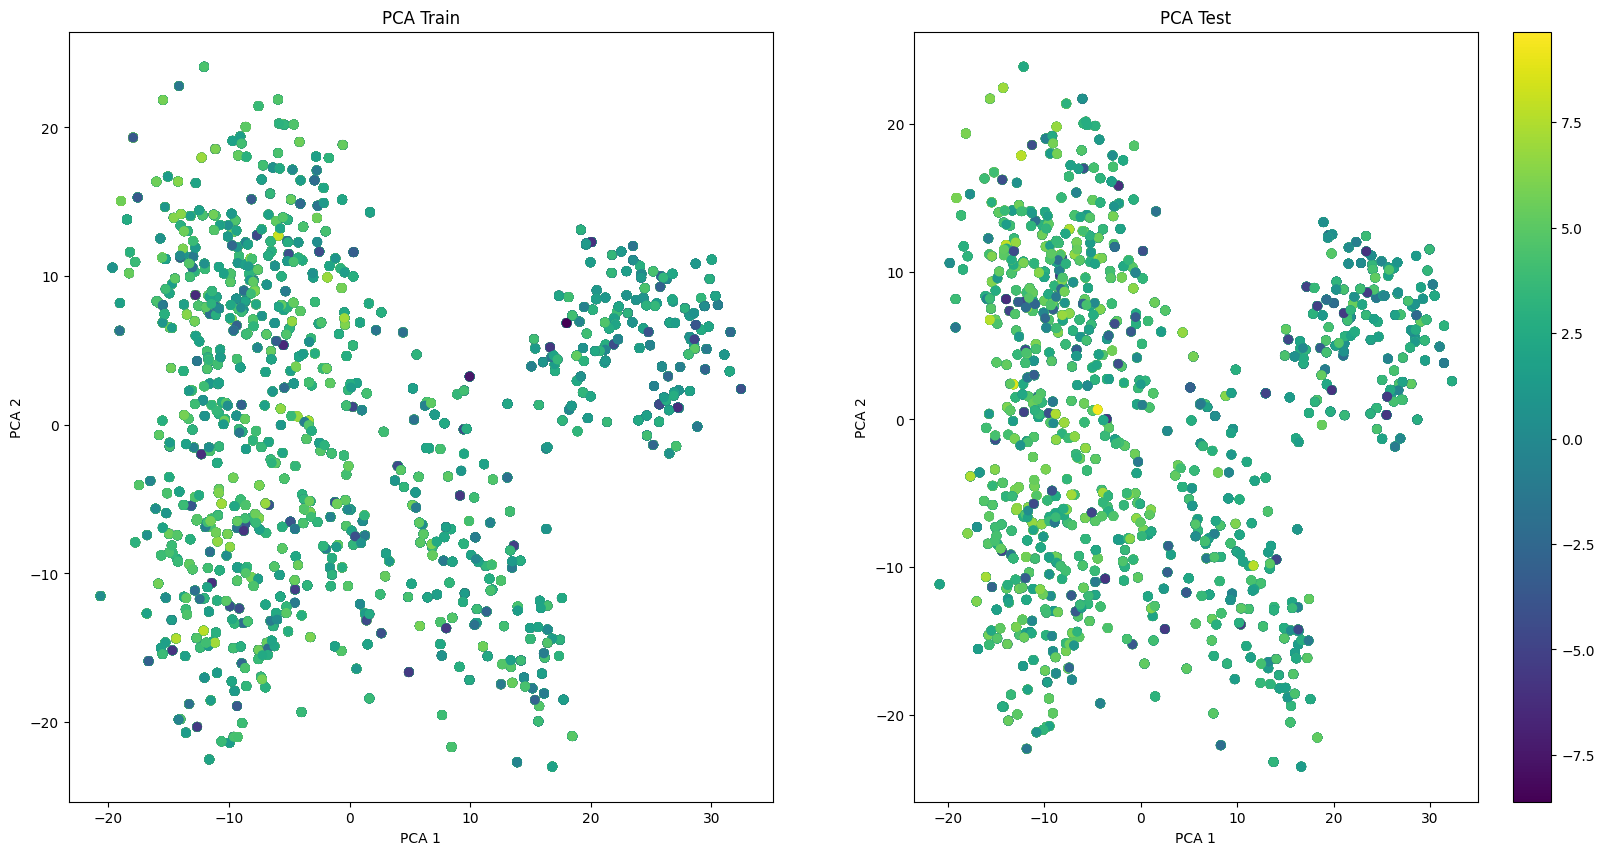

In [24]:
#plot and compare
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA Train')
plt.subplot(1, 2, 2)
plt.scatter(x_test_pca[:, 0], x_test_pca[:, 1], c=y_test, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA Test')
plt.colorbar()
plt.show()


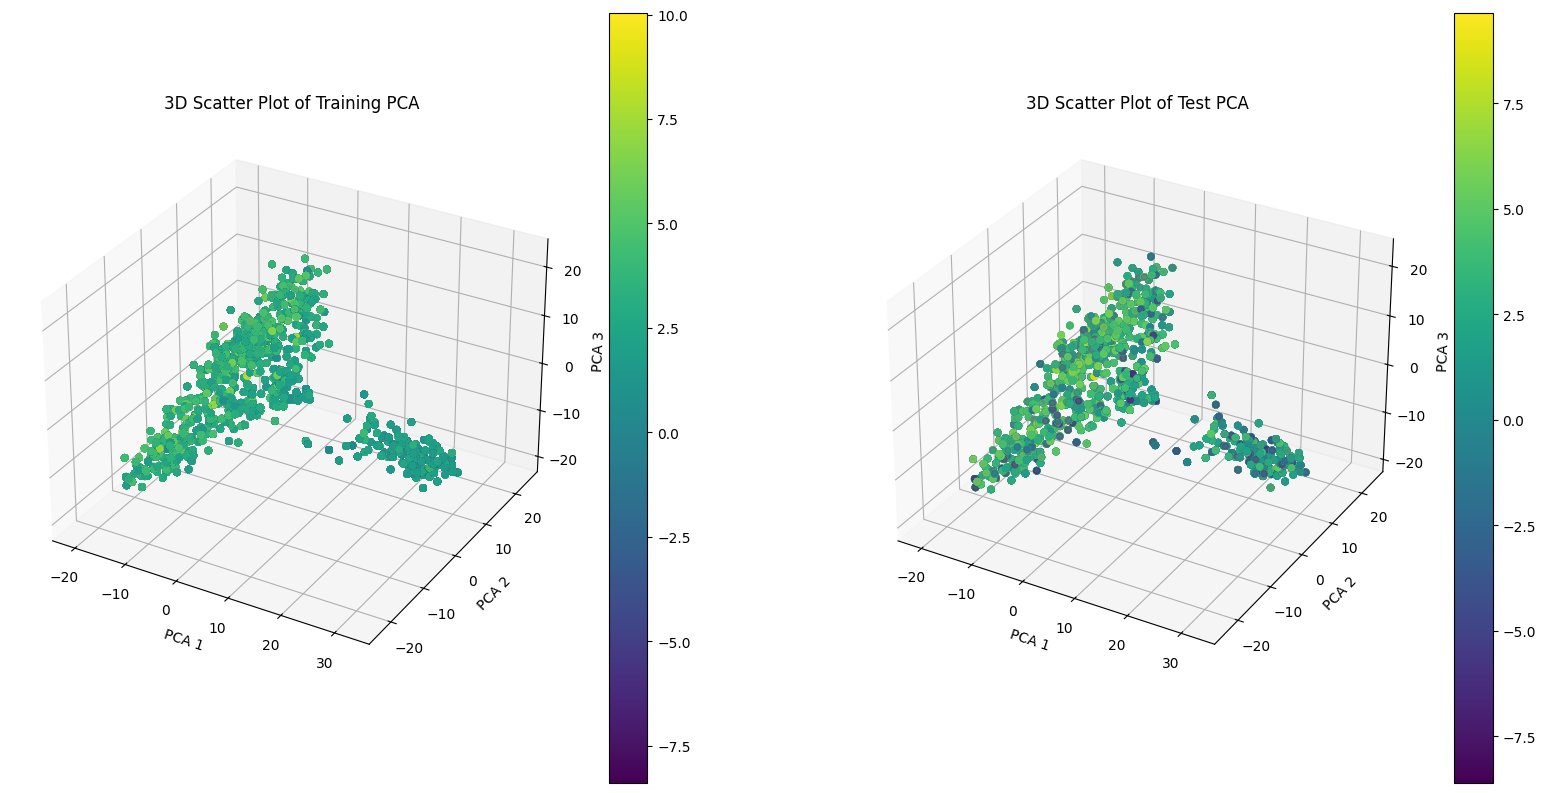

In [26]:
from mpl_toolkits.mplot3d import Axes3D

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection':'3d'})

# Assuming that your classes are stored in y_train and y_test
scatter1 = ax1.scatter(x_train_pca[:, 0], x_train_pca[:, 1], x_train_pca[:, 2], c=y_train, cmap='viridis')
scatter2 = ax2.scatter(x_test_pca[:, 0], x_test_pca[:, 1], x_test_pca[:, 2], c=y_test, cmap='viridis')

ax1.set_xlabel("PCA 1")
ax1.set_ylabel("PCA 2")
ax1.set_zlabel("PCA 3")
ax1.set_title('3D Scatter Plot of Training PCA')

ax2.set_xlabel("PCA 1")
ax2.set_ylabel("PCA 2")
ax2.set_zlabel("PCA 3")
ax2.set_title('3D Scatter Plot of Test PCA')

fig.colorbar(scatter1, ax=ax1)
fig.colorbar(scatter2, ax=ax2)

plt.show()